# Comparing OLPS algorithms on a diversified set of ETFs

[Online Portfolio Selection: A Survey by Bin Li and Steven C. H. Hoi](http://arxiv.org/abs/1212.2129) (OLPS) reviews the growing literature in multi-period portfolio allocation optimization, with [On-Line Portfolio Selection with Moving Average Reversion](http://arxiv.org/abs/1206.4626) (OLMAR) claiming superior performance on several datasets.

Here we use [Mojmir Vinkler's](https://www.linkedin.com/profile/view?id=210899853) [implementation](https://github.com/Marigold/universal-portfolios) (which was the basis of his [thesis](http://is.muni.cz/th/358102/prif_m/?lang=en;id=183901) ) and extend [his comparison](http://nbviewer.ipython.org/github/Marigold/universal-portfolios/blob/master/On-line%20portfolios.ipynb) to a more recent timeline, and use ETFs to avoid survivorship bias as suggested by [Ernie Chan](http://epchan.blogspot.cz/2007/01/universal-portfolios.html), and test the suitability of this family of algorithms to active trading.

You will first need to: ```pip install universal-portfolios```

Initialize and set debugging level to `debug` to track progress.

In [218]:
%matplotlib inline
import pandas as pd
from universal import tools
from universal import algos
import logging
# we would like to see algos progress
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.DEBUG)

import matplotlib as mpl
import matplotlib.pyplot as plt
# increase the size of graphs
mpl.rcParams['figure.figsize'] = (16, 10)
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['lines.linewidth'] = 1

We pick 6 ETFs to avoid survivorship bias and capture broad market diversification. We select the longest running ETF per assset class.

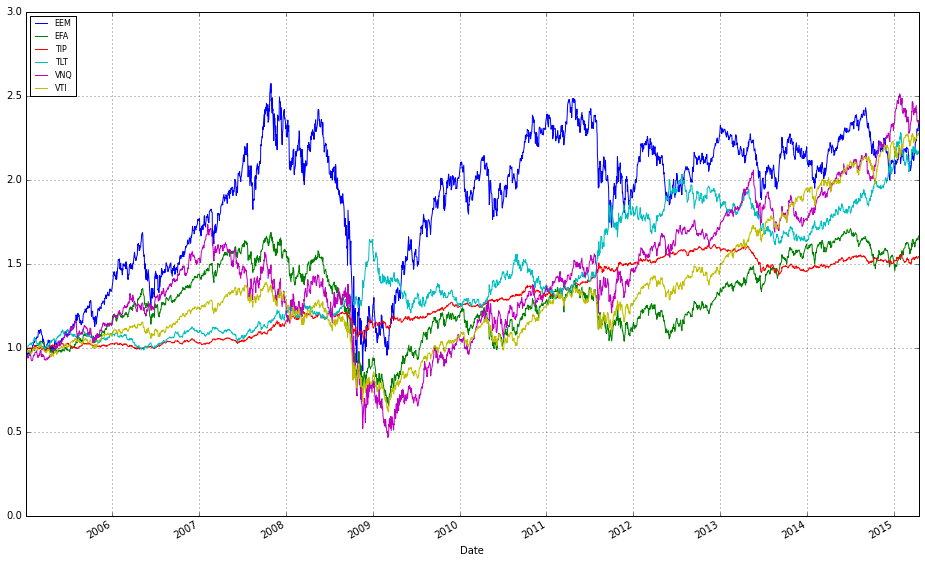

In [143]:
from pandas.io.data import DataReader
from datetime import datetime

# load data from Yahoo
yahoo_data = DataReader(['VTI', 'EFA', 'EEM', 'TLT', 'TIP', 'VNQ'], 'yahoo', start=datetime(2005,1,1))['Adj Close']

# plot normalized prices of these stocks
(yahoo_data / yahoo_data.iloc[0,:]).plot()

Instead of using fixed parameters, we will test several `window` parameters with the `run_combination` function. 

Summary for window=3:
    Profit factor: 1.28
    Sharpe ratio: 1.16
    Information ratio (wrt UCRP): 1.18
    Annualized return: 39.55%
    Longest drawdown: 161 days
    Winning days: 55.0%
        
Summary for window=5:
    Profit factor: 1.26
    Sharpe ratio: 1.13
    Information ratio (wrt UCRP): 1.12
    Annualized return: 37.98%
    Longest drawdown: 291 days
    Winning days: 54.9%
        
Summary for window=10:
    Profit factor: 1.25
    Sharpe ratio: 1.04
    Information ratio (wrt UCRP): 1.07
    Annualized return: 35.95%
    Longest drawdown: 244 days
    Winning days: 55.0%
        
Summary for window=15:
    Profit factor: 1.24
    Sharpe ratio: 0.98
    Information ratio (wrt UCRP): 1.00
    Annualized return: 33.82%
    Longest drawdown: 209 days
    Winning days: 54.4%
        


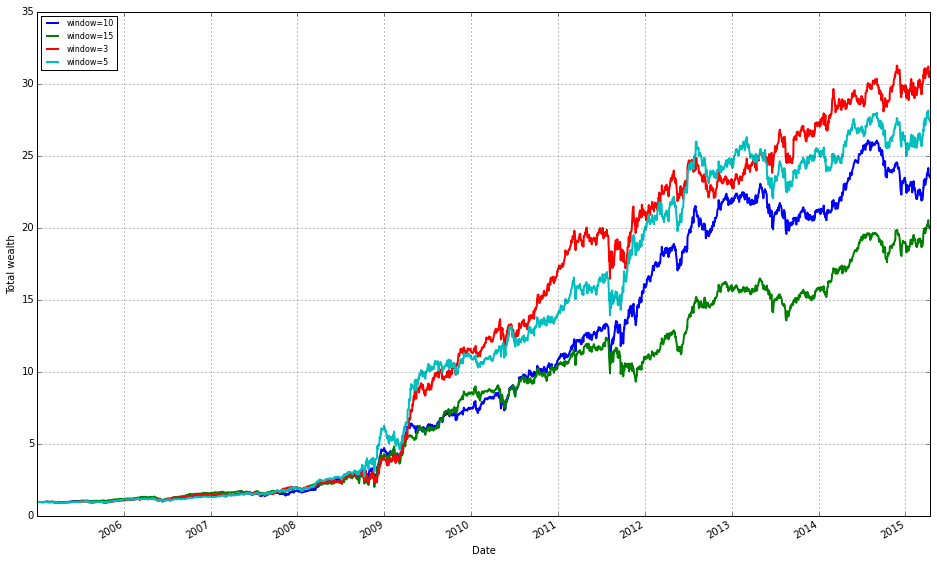

In [144]:
list_result = algos.OLMAR.run_combination(yahoo_data, window=[3,5,10,15], eps=10)
print(list_result.summary())
list_result.plot()

In this instance a window 3 is the best, but the recommendation is for a window of 5, and other runs I have done I fond 5 to be the best.  Let's vary eps.

Summary for eps=3:
    Profit factor: 1.26
    Sharpe ratio: 1.12
    Information ratio (wrt UCRP): 1.11
    Annualized return: 37.62%
    Longest drawdown: 292 days
    Winning days: 54.8%
        
Summary for eps=5:
    Profit factor: 1.26
    Sharpe ratio: 1.13
    Information ratio (wrt UCRP): 1.12
    Annualized return: 38.05%
    Longest drawdown: 292 days
    Winning days: 54.9%
        
Summary for eps=10:
    Profit factor: 1.26
    Sharpe ratio: 1.13
    Information ratio (wrt UCRP): 1.12
    Annualized return: 37.98%
    Longest drawdown: 291 days
    Winning days: 54.9%
        
Summary for eps=15:
    Profit factor: 1.26
    Sharpe ratio: 1.12
    Information ratio (wrt UCRP): 1.12
    Annualized return: 37.98%
    Longest drawdown: 291 days
    Winning days: 54.9%
        


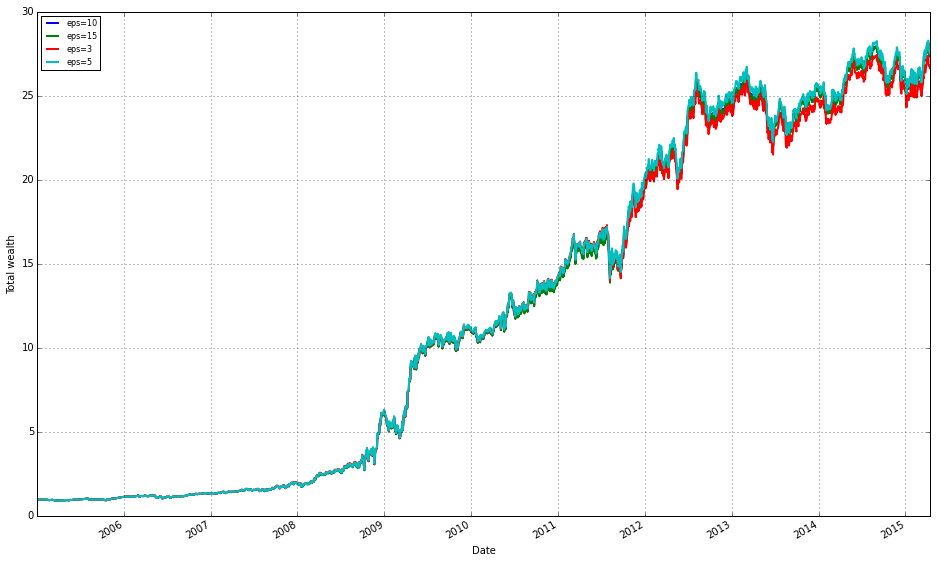

In [145]:
list_result = algos.OLMAR.run_combination(yahoo_data, window=5, eps=[3,5,10,15])
print(list_result.summary())
list_result.plot()

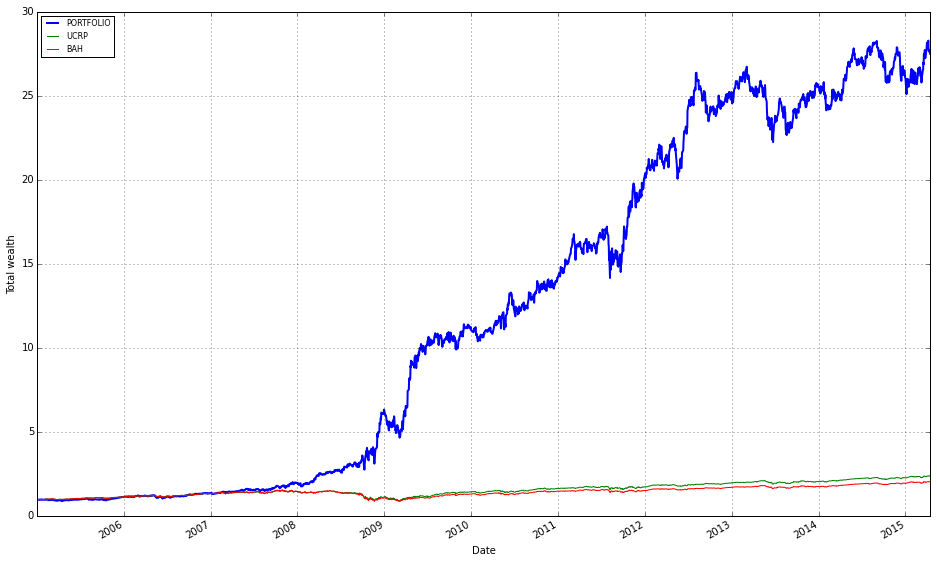

In [146]:
# OLMAR vs UCRP
best_result = list_result[1]
best_result.plot(ucrp=True, bah=True, weights=False, assets=False)

Let's see how individual ETFs contribute to portfolio equity.

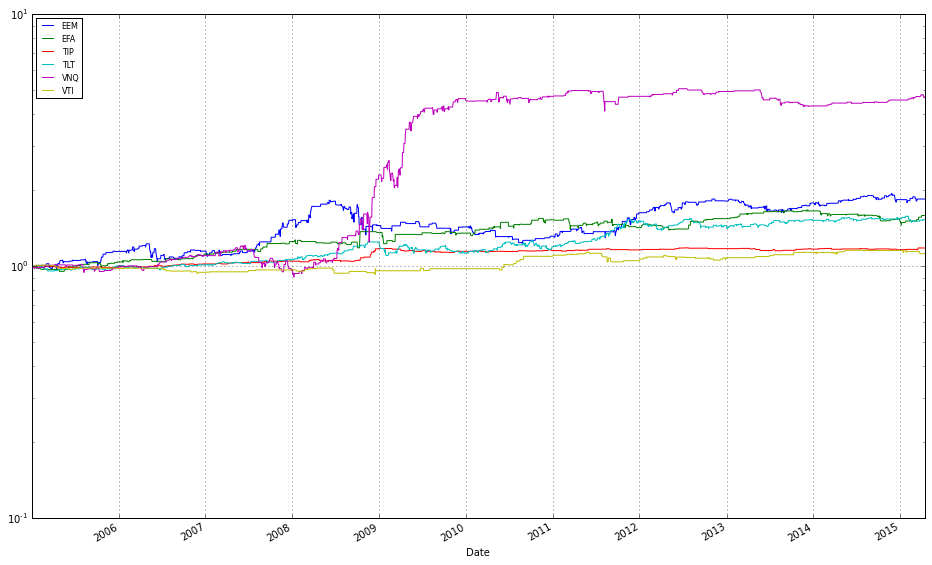

In [147]:
best_result = list_result[1]
best_result.plot_decomposition(legend=True, logy=True)

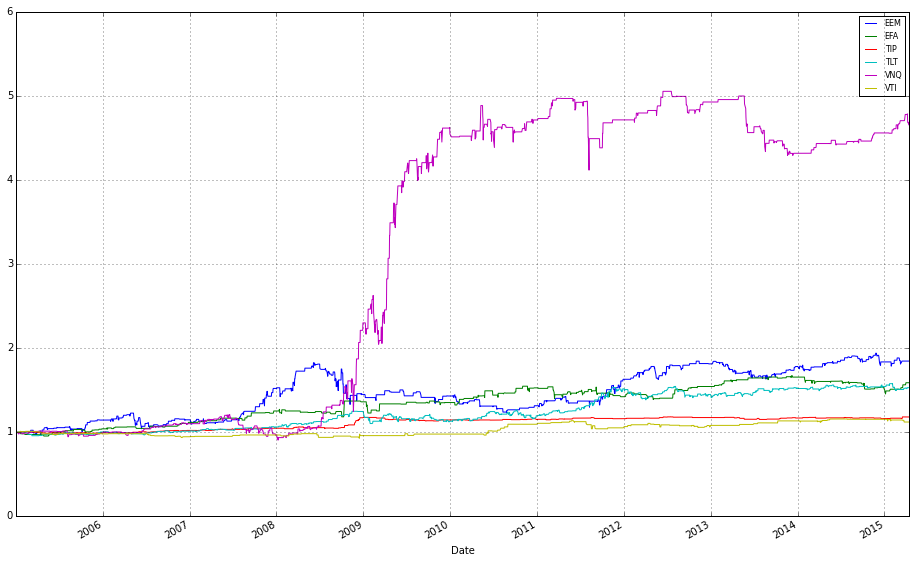

In [148]:
best_result.plot_decomposition(legend=True, logy=False)

Let's look at portfolio allocations, but it seems hard to read.

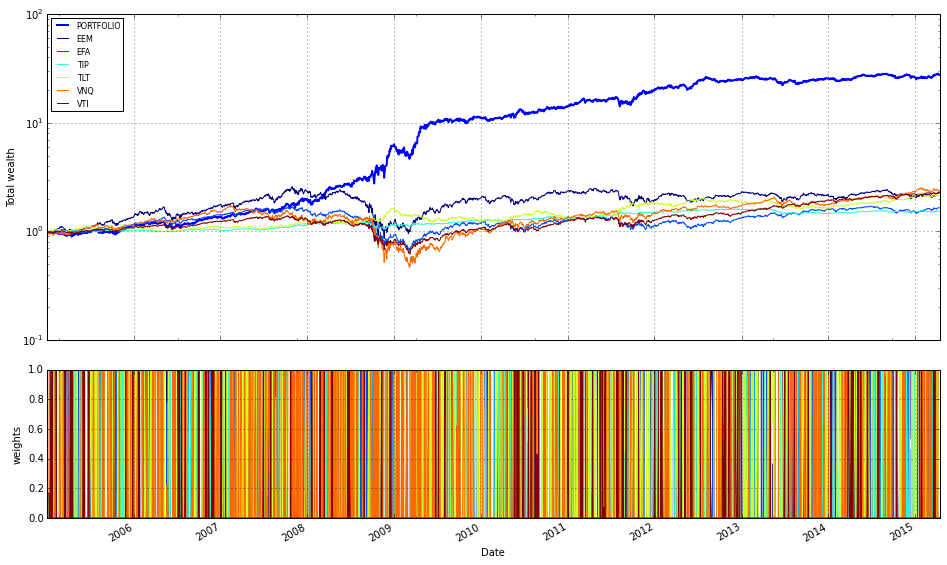

In [149]:
best_result.plot(weights=True, assets=True, ucrp=False, logy=True)

VNQ is the big driver of wealth (log scale). Let's test the strategy by removing the most profitable stock and comparing Total Wealth.

Summary:
    Profit factor: 1.22
    Sharpe ratio: 0.95
    Information ratio (wrt UCRP): 0.86
    Annualized return: 27.04%
    Longest drawdown: 155 days
    Winning days: 54.8%
        


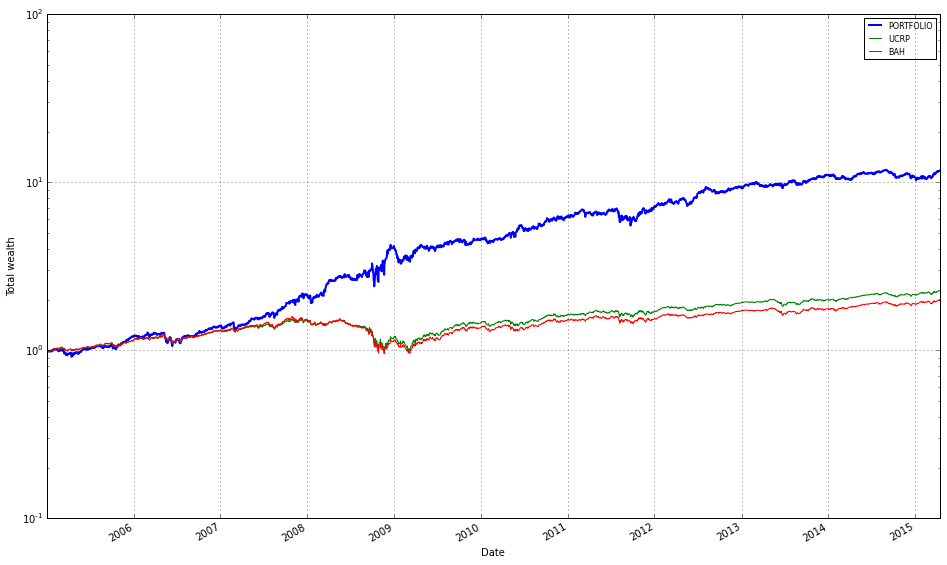

In [150]:
# find the name of the most profitable asset
most_profitable = best_result.equity_decomposed.iloc[-1].argmax()

# rerun algorithm on data without it
result_without = algo.run(yahoo_data.drop([most_profitable], 1))

# and print results
print(result_without.summary())
result_without.plot(weights=False, assets=False, bah=True, ucrp=True, logy=True)

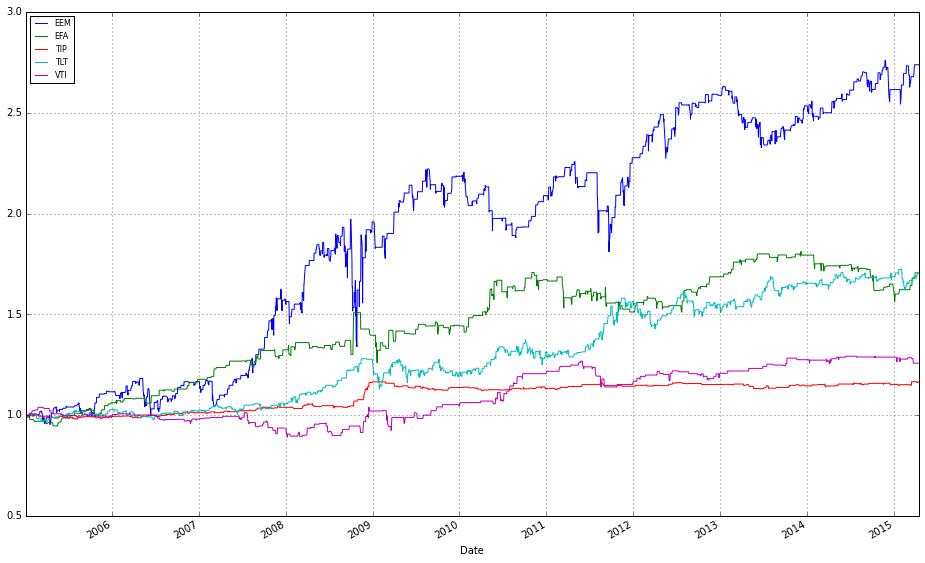

In [151]:
result_without.plot_decomposition(legend=True, logy=False)

Let's add fees of 0.1% per transaction (we pay \$1 for every \$1000 of stocks bought or sold).

Summary:
    Profit factor: 1.05
    Sharpe ratio: 0.25
    Information ratio (wrt UCRP): -0.07
    Annualized return: 7.27%
    Longest drawdown: 808 days
    Winning days: 50.8%
        


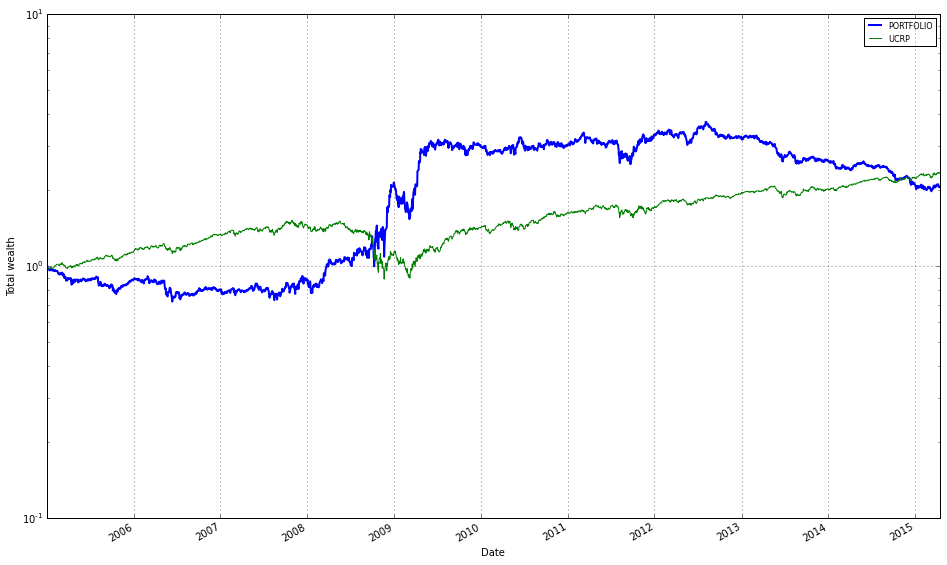

In [152]:
best_result.fee = 0.001
print(best_result.summary())
best_result.plot(weights=False, assets=False, bah=False, ucrp=True, logy=True)

The results now seem to fall in line with the avreage market returns, with a decreased Sharpe Ratio from 1.13 to 0.25, which is below the ~0.5 market Sharpe, and an annualized return from 38% to 7.27%. Not exactly stunning results.

# Comparing to the rest of the algorithms

In [159]:
# this takes many minutes to run

anticor = algos.Anticor().run(yahoo_data)
bah  = algos.BAH().run(yahoo_data)
bcrp = algos.BCRP().run(yahoo_data)
bnn  = algos.BNN().run(yahoo_data)
corn = algos.CORN().run(yahoo_data)
crp  = algos.CRP().run(yahoo_data)
cwmr = algos.CWMR().run(yahoo_data)
eg   = algos.EG().run(yahoo_data)
kelly= algos.Kelly().run(yahoo_data)
olmar= algos.OLMAR().run(yahoo_data)
ons  = algos.ONS().run(yahoo_data)
pamr = algos.PAMR().run(yahoo_data)
# rmr  = algos.RMR().run(yahoo_data)  # error: ValueError: No axis named 1 for object type <class 'pandas.core.series.Series'>
up   = algos.UP().run(yahoo_data)

In [221]:
# Let's make sure the fees are 0 at first

anticor.fee = 0.0
bah.fee = 0.0
bcrp.fee = 0.0
bnn.fee = 0.0
corn.fee = 0.0
crp.fee = 0.0
cwmr.fee = 0.0
eg.fee = 0.0
kelly.fee = 0.0
olmar.fee = 0.0
ons.fee = 0.0
pamr.fee = 0.0
# rmr.fee = 0.0
up.fee = 0.0

In [222]:
cm = plt.get_cmap('gist_rainbow')

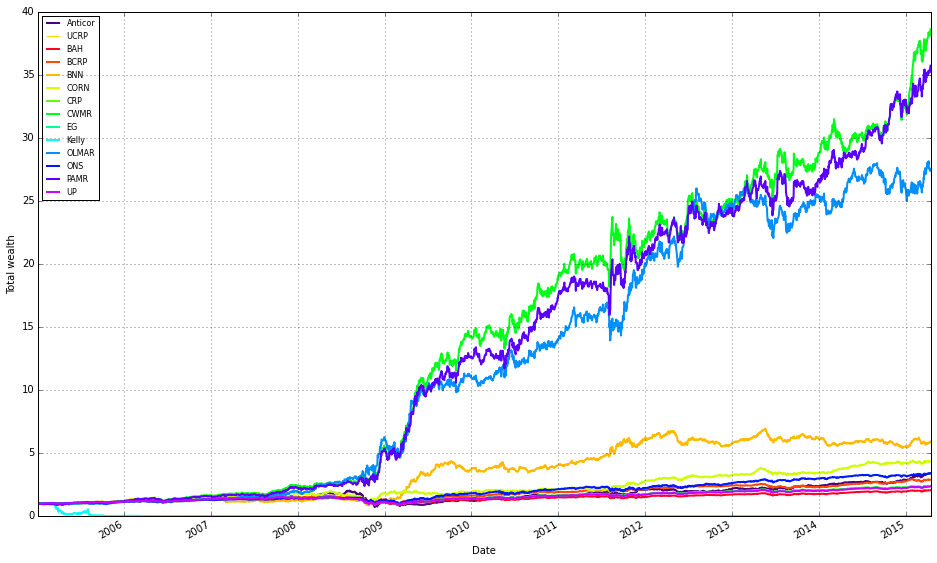

In [223]:
# plot as if we had no fees
ax = anticor.plot(assets=False, weights=False, ucrp=True, portfolio_label="Anticor")
ax[0].set_color_cycle([cm(1.*i/12) for i in range(12)])
bah.plot(assets=False, weights=False, ax=ax[0], portfolio_label='BAH')
bcrp.plot(assets=False, weights=False, ax=ax[0], portfolio_label='BCRP')
bnn.plot(assets=False, weights=False, ax=ax[0], portfolio_label='BNN')
corn.plot(assets=False, weights=False, ax=ax[0], portfolio_label='CORN')
crp.plot(assets=False, weights=False, ax=ax[0], portfolio_label='CRP')
cwmr.plot(assets=False, weights=False, ax=ax[0], portfolio_label='CWMR')
eg.plot(assets=False, weights=False, ax=ax[0], portfolio_label='EG')
kelly.plot(assets=False, weights=False, ax=ax[0], portfolio_label='Kelly')
olmar.plot(assets=False, weights=False, ax=ax[0], portfolio_label='OLMAR')
ons.plot(assets=False, weights=False, ax=ax[0], portfolio_label='ONS')
pamr.plot(assets=False, weights=False, ax=ax[0], portfolio_label='PAMR')
#rmr.plot(assets=False, weights=False, ax=ax[0], portfolio_label='RMR')
up.plot(assets=False, weights=False, ax=ax[0], portfolio_label='UP')

In [224]:
# Let's add fees of 0.1% per transaction (we pay $1 for every $1000 of stocks bought or sold).

anticor.fee = 0.001
bah.fee = 0.001
bcrp.fee = 0.001
bnn.fee = 0.001
corn.fee = 0.001
crp.fee = 0.001
cwmr.fee = 0.001
eg.fee = 0.001
kelly.fee = 0.001
olmar.fee = 0.001
ons.fee = 0.001
pamr.fee = 0.001
# rmr.fee = 0.001
up.fee = 0.001

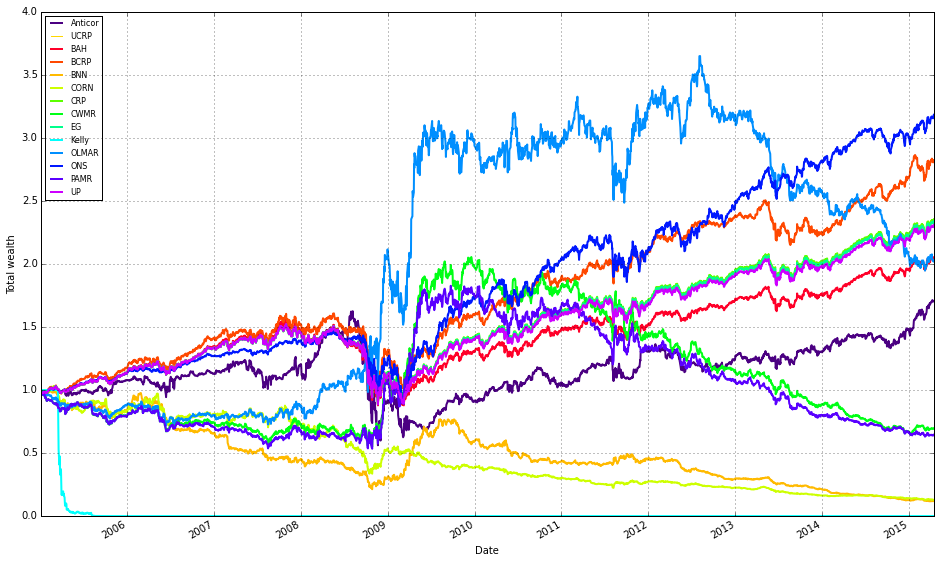

In [225]:
# now with fees
ax = anticor.plot(assets=False, weights=False, ucrp=True, portfolio_label="Anticor") #, colormap='Reds')
ax[0].set_color_cycle([cm(1.*i/12) for i in range(12)])
bah.plot(assets=False, weights=False, ax=ax[0], portfolio_label='BAH')
bcrp.plot(assets=False, weights=False, ax=ax[0], portfolio_label='BCRP')
bnn.plot(assets=False, weights=False, ax=ax[0], portfolio_label='BNN')
corn.plot(assets=False, weights=False, ax=ax[0], portfolio_label='CORN')
crp.plot(assets=False, weights=False, ax=ax[0], portfolio_label='CRP')
cwmr.plot(assets=False, weights=False, ax=ax[0], portfolio_label='CWMR')
eg.plot(assets=False, weights=False, ax=ax[0], portfolio_label='EG')
kelly.plot(assets=False, weights=False, ax=ax[0], portfolio_label='Kelly')
olmar.plot(assets=False, weights=False, ax=ax[0], portfolio_label='OLMAR')
ons.plot(assets=False, weights=False, ax=ax[0], portfolio_label='ONS')
pamr.plot(assets=False, weights=False, ax=ax[0], portfolio_label='PAMR')
#rmr.plot(assets=False, weights=False, ax=ax[0], portfolio_label='RMR')
up.plot(assets=False, weights=False, ax=ax[0], portfolio_label='UP')

# BAH on OLMAR

Since we don't know the best parameters in hindsight, we will invest equal money in each of them in the beginning and let them run; a _buy and hold_ strategy. Portfolio equities in `list_result` can be regarded as stock prices and used as an input for new algo (_buy and hold_ in this case).
To compare it with individual assets or uniform constant rebalanced portfolio, use parameters `assets` and `ucrp`.

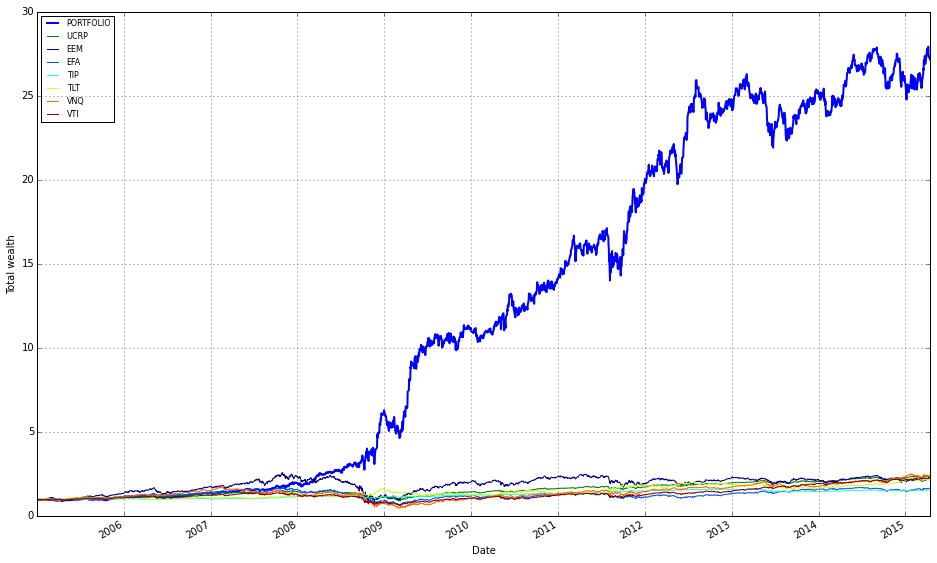

In [109]:
# run buy and hold on OLMAR results and show its equity together with original assets
algos.BAH().run(list_result).plot(assets=True, weights=False, ucrp=True)

# Start in 2010

The 2008-2009 recession was unique.  Let's try it all again starting in 2010.

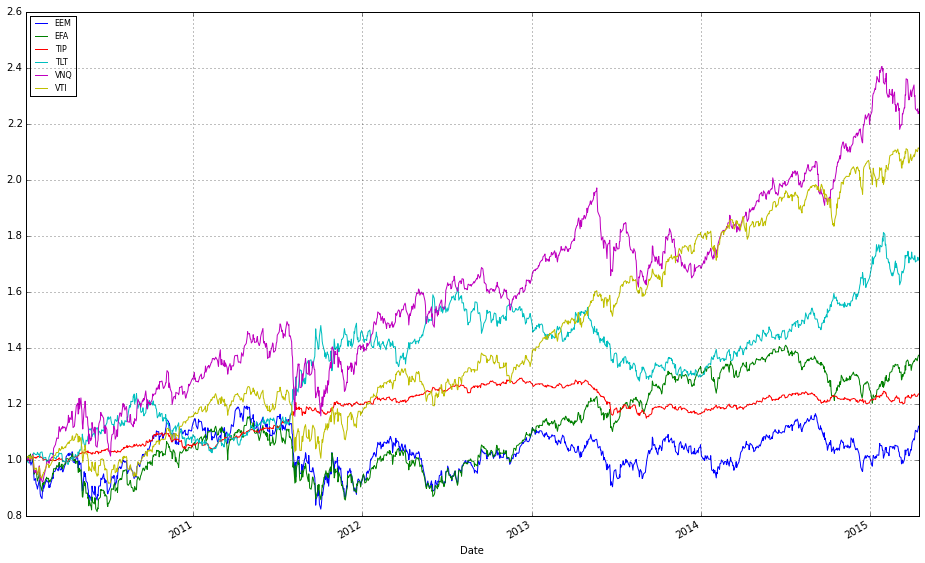

In [110]:
# load data from Yahoo
data_2010 = DataReader(['VTI', 'EFA', 'EEM', 'TLT', 'TIP', 'VNQ'], 'yahoo', start=datetime(2010,1,1))['Adj Close']

# plot normalized prices of these stocks
(data_2010 / data_2010.iloc[0,:]).plot()

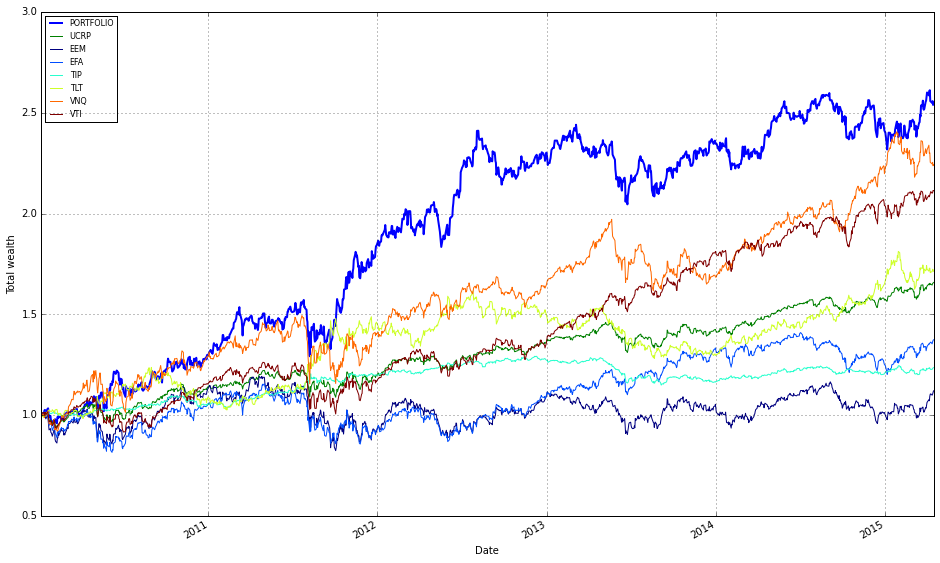

In [116]:
olmar_2010 = algos.OLMAR().run(data_2010)
olmar_2010.plot(assets=True, weights=False, ucrp=True)

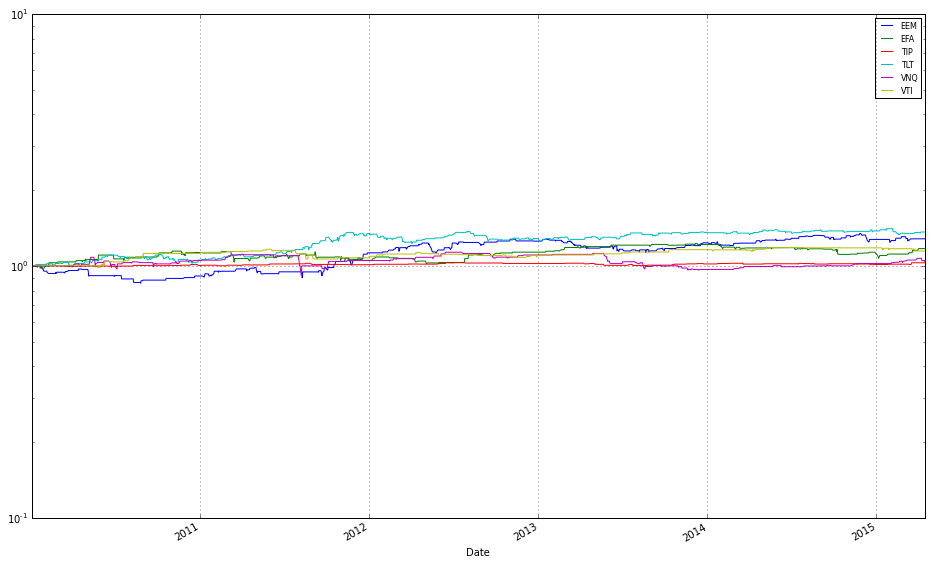

In [125]:
olmar_2010.plot_decomposition(legend=True, logy=True)

# SPY / TLT portfolio comparison

Let's simplify this even further and just look at SPY and TLT.

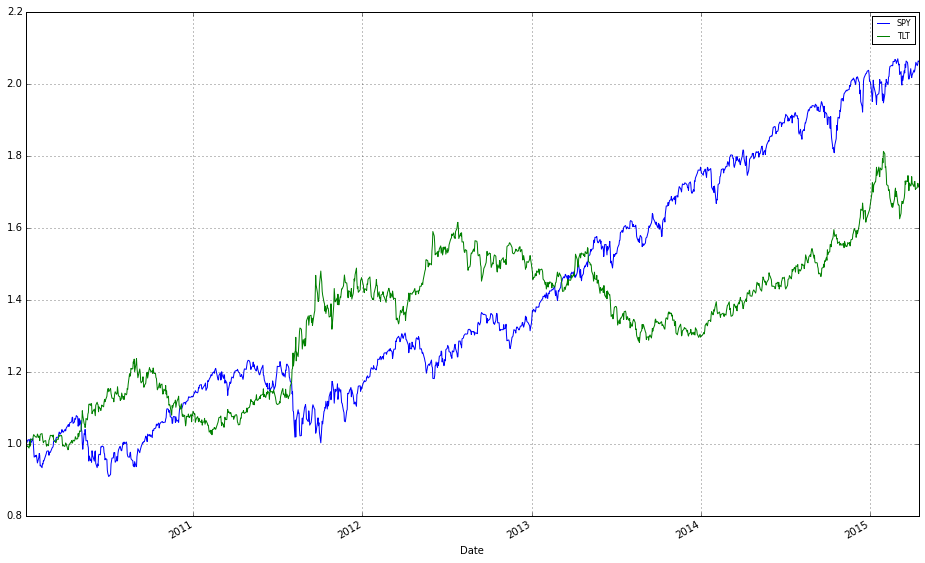

In [118]:
# load data from Yahoo
spy_tlt_data = DataReader(['SPY', 'TLT'], 'yahoo', start=datetime(2010,1,1))['Adj Close']

# plot normalized prices of these stocks
(spy_tlt_data / spy_tlt_data.iloc[0,:]).plot()

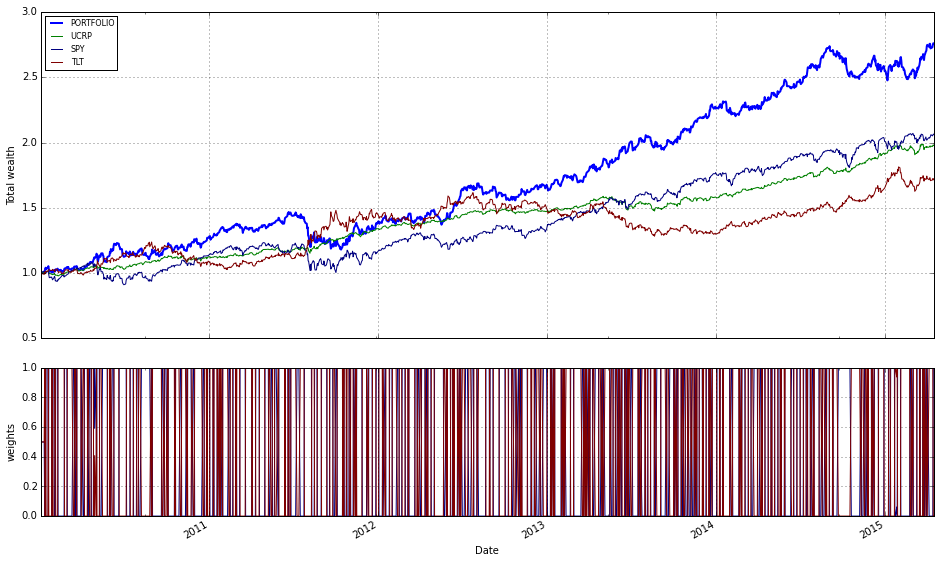

In [121]:
spy_tlt_olmar_2010 = algos.OLMAR().run(spy_tlt_data)
spy_tlt_olmar_2010.plot(assets=True, weights=True, ucrp=True)

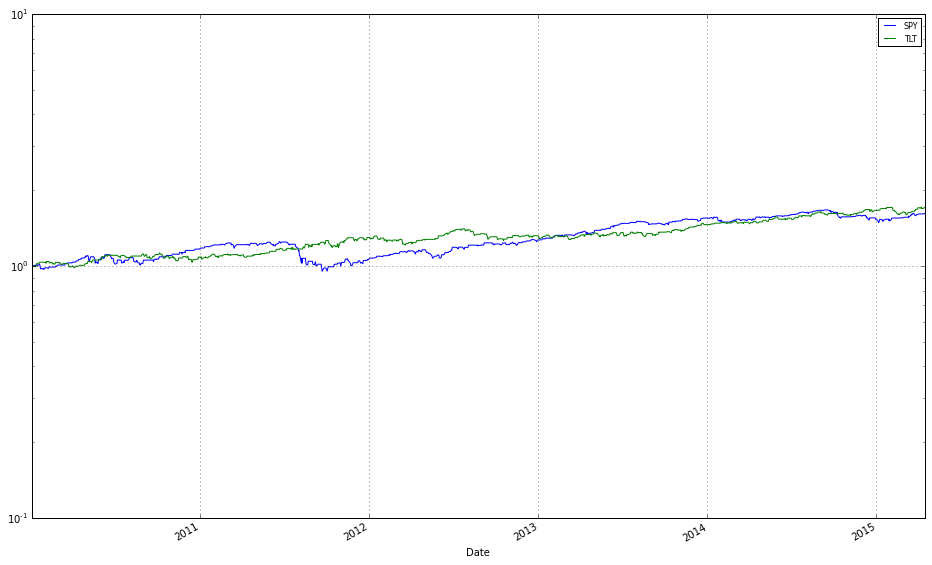

In [122]:
spy_tlt_olmar_2010.plot_decomposition(legend=True, logy=True)

In [123]:
print(best_result.summary())

Summary:
    Profit factor: 1.05
    Sharpe ratio: 0.25
    Information ratio (wrt UCRP): -0.07
    Annualized return: 7.27%
    Longest drawdown: 808 days
    Winning days: 50.8%
        


Hm, not so good after all. 